<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/4_3_tuned_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

!pip install keras-tuner

from kerastuner.tuners import RandomSearch

2.12.0


<ipython-input-2-9bdaee288ddc>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


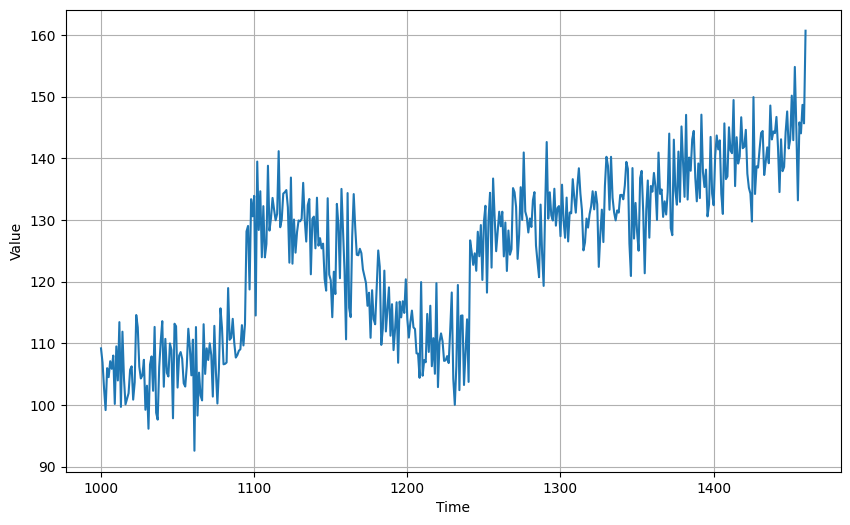

In [3]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope*time

def seasonal_pattern(season_time):
  """Just an arbitrary pattern"""
  return np.where(season_time < 0.4, np.cos(season_time * 2 *np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """Repeats the same pattern at each period"""
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time = np.arange(4*365+1, dtype="float32")
baseline=10
series = trend(time, 0.1)
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
# from tensorflow.python.ops.gen_dataset_ops import window_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [4]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=hp.Int('units', )))